In [1]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Enable plots inside the Jupyter NotebookLet the
%matplotlib inline

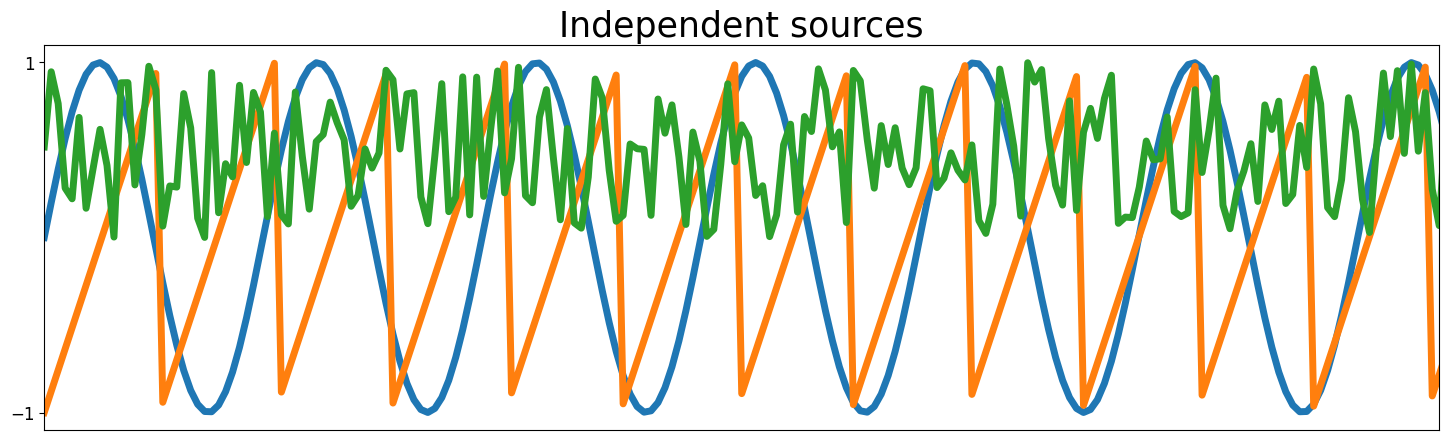

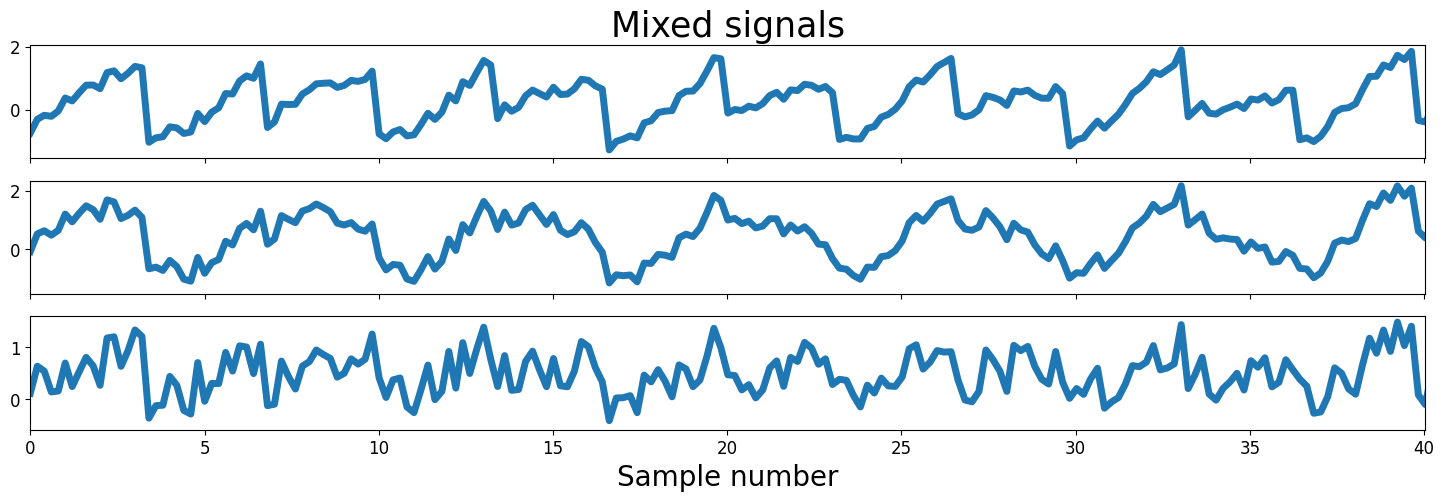

In [2]:
# Set a seed for the random number generator for reproducibility
np.random.seed(23)

# Number of samples
ns = np.linspace(0, 200, 1000)

# Source matrix
S = np.array([np.sin(ns * 1),
              signal.sawtooth(ns * 1.9),
              np.random.random(len(ns))]).T

# Mixing matrix
A = np.array([[0.5, 1, 0.2],
              [1, 0.5, 0.4],
              [0.5, 0.8, 1]])

# Mixed signal matrix
X = S.dot(A).T
# Plot sources & signals
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(ns, S, lw=5)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_xlim(ns[0], ns[200])
ax.tick_params(labelsize=12)
ax.set_title('Independent sources', fontsize=25)

fig, ax = plt.subplots(3, 1, figsize=[18, 5], sharex=True)
ax[0].plot(ns, X[0], lw=5)
ax[0].set_title('Mixed signals', fontsize=25)
ax[0].tick_params(labelsize=12)

ax[1].plot(ns, X[1], lw=5)
ax[1].tick_params(labelsize=12)
ax[1].set_xlim(ns[0], ns[-1])

ax[2].plot(ns, X[2], lw=5)
ax[2].tick_params(labelsize=12)
ax[2].set_xlim(ns[0], ns[-1])
ax[2].set_xlabel('Sample number', fontsize=20)
ax[2].set_xlim(ns[0], ns[200])

plt.show()

In [3]:
def center(x):
    mean = np.mean(x, axis=1, keepdims=True)
    centered =  x - mean
    return centered, mean

In [4]:
def covariance(x):
    mean = np.mean(x, axis=1, keepdims=True)
    n = np.shape(x)[1] - 1
    m = x - mean

    return (m.dot(m.T))/n

In [5]:
def whiten(x):
    # Calculate the covariance matrix
    coVarM = covariance(X)

    # Single value decoposition
    U, S, V = np.linalg.svd(coVarM)

    # Calculate diagonal matrix of eigenvalues
    d = np.diag(1.0 / np.sqrt(S))

    # Calculate whitening matrix
    whiteM = np.dot(U, np.dot(d, U.T))

    # Project onto whitening matrix
    Xw = np.dot(whiteM, X)

    return Xw, whiteM

In [6]:
def fastIca(signals,  alpha = 1, thresh=1e-8, iterations=5000):
    m, n = signals.shape

    # Initialize random weights
    W = np.random.rand(m, m)

    for c in range(m):
            w = W[c, :].copy().reshape(m, 1)
            w = w / np.sqrt((w ** 2).sum())

            i = 0
            lim = 100
            while ((lim > thresh) & (i < iterations)):

                # Dot product of weight and signal
                ws = np.dot(w.T, signals)

                # Pass w*s into contrast function g
                wg = np.tanh(ws * alpha).T
                print(wg.shape)
                # Pass w*s into g prime
                wg_ = (1 - np.square(np.tanh(ws))) * alpha

                # Update weights
                wNew = (signals * wg.T).mean(axis=1) - wg_.mean() * w.squeeze()

                # Decorrelate weights
                wNew = wNew - np.dot(np.dot(wNew, W[:c].T), W[:c])
                wNew = wNew / np.sqrt((wNew ** 2).sum())

                # Calculate limit condition
                lim = np.abs(np.abs((wNew * w).sum()) - 1)

                # Update weights
                w = wNew

                # Update counter
                i += 1

            W[c, :] = w.T
    return W

In [7]:
# Center signals
Xc, meanX = center(X)

# Whiten mixed signals
Xw, whiteM = whiten(Xc)

In [8]:
print(np.round(covariance(Xw)))

[[ 1. -0. -0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]


(1000, 1)
(1000,)
(1000,)
(1000,)
(1000,)
(1000, 1)
(1000,)
(1000,)
(1000,)
(1000,)
(1000, 1)
(1000,)


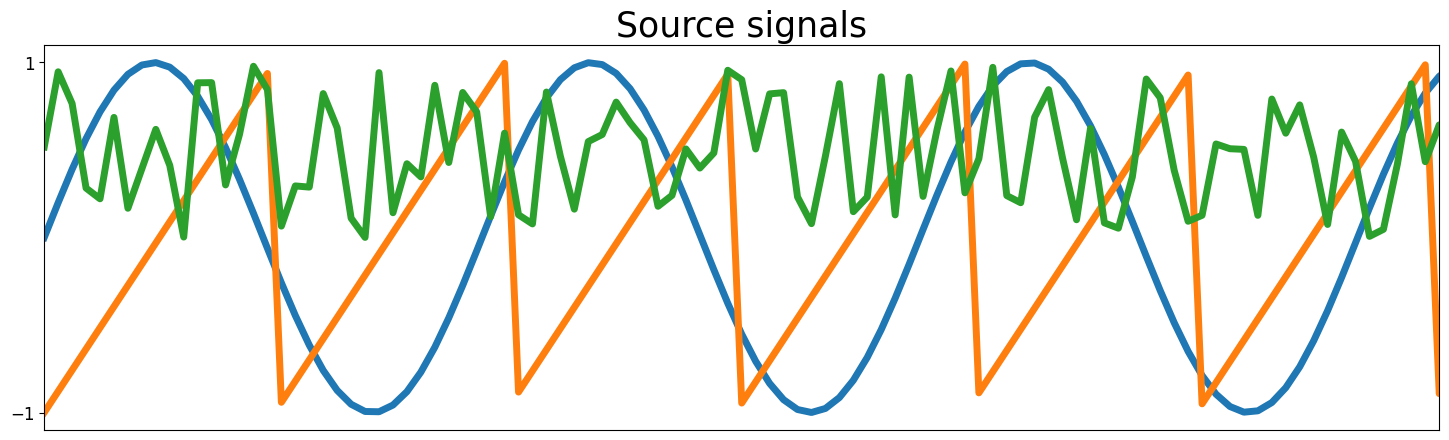

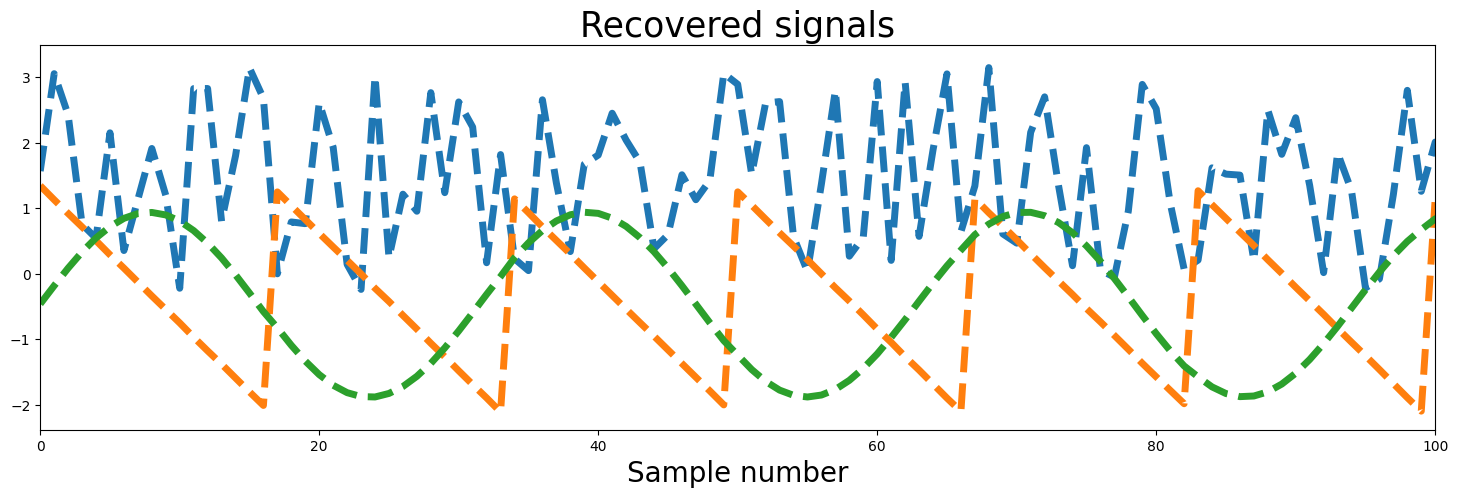

In [9]:
W = fastIca(Xw,  alpha=1)

#Un-mix signals using
unMixed = Xw.T.dot(W.T)

# Subtract mean
unMixed = (unMixed.T - meanX).T
# Plot input signals (not mixed)
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(S, lw=5)
ax.tick_params(labelsize=12)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_title('Source signals', fontsize=25)
ax.set_xlim(0, 100)

fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(unMixed, '--', label='Recovered signals', lw=5)
ax.set_xlabel('Sample number', fontsize=20)
ax.set_title('Recovered signals', fontsize=25)
ax.set_xlim(0, 100)

plt.show()